# This notebook serves as the initial inspection phase for the Lichess Elite database. Before running the heavy ETL pipeline (scripts/process_data.py), we need to understand the data distribution, verify the Elo ratings, and ensure our filtering logic is sound.

# 1. Setup & Stream Test
Since the .pgn.zst files are massive, we use a streaming decompressor to peek inside the first few hundred games without exhausting memory.


In [3]:
import chess.pgn
import zstandard as zstd
import io
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

RAW_DATA_PATH = "lichess_db_standard_rated_2026-01.pgn.zst"

def peek_games(n=1000):
    games_metadata = []
    dctx = zstd.ZstdDecompressor()
    
    with open(RAW_DATA_PATH, 'rb') as fh:
        with dctx.stream_reader(fh) as reader:
            text_stream = io.TextIOWrapper(reader, encoding='utf-8', errors='replace')
            for _ in tqdm(range(n)):
                game = chess.pgn.read_game(text_stream)
                if game is None: break
                
                h = game.headers
                games_metadata.append({
                    "WhiteElo": int(h.get("WhiteElo", 0)),
                    "BlackElo": int(h.get("BlackElo", 0)),
                    "Event": h.get("Event", ""),
                    "Termination": h.get("Termination", ""),
                    "Result": h.get("Result", ""),
                    "PlyCount": h.get("PlyCount", 0)
                })
    return pd.DataFrame(games_metadata)

df = peek_games(5000)
df.head()

100%|██████████| 5000/5000 [00:07<00:00, 698.61it/s]


,WhiteElo,BlackElo,Event,Termination,Result,PlyCount
0,1523,1538,Rated Blitz game,Normal,1-0,0
1,1796,1809,Rated Blitz game,Normal,1-0,0
2,2177,2109,Rated Blitz game,Normal,1-0,0
3,1960,2042,Rated Blitz game,Normal,0-1,0
4,2066,1969,Rated Blitz game,Normal,0-1,0


# 2. Statistical Analysis
We need to verify if the 2400+ Elo filter is aggressive enough and how many games it actually retains.

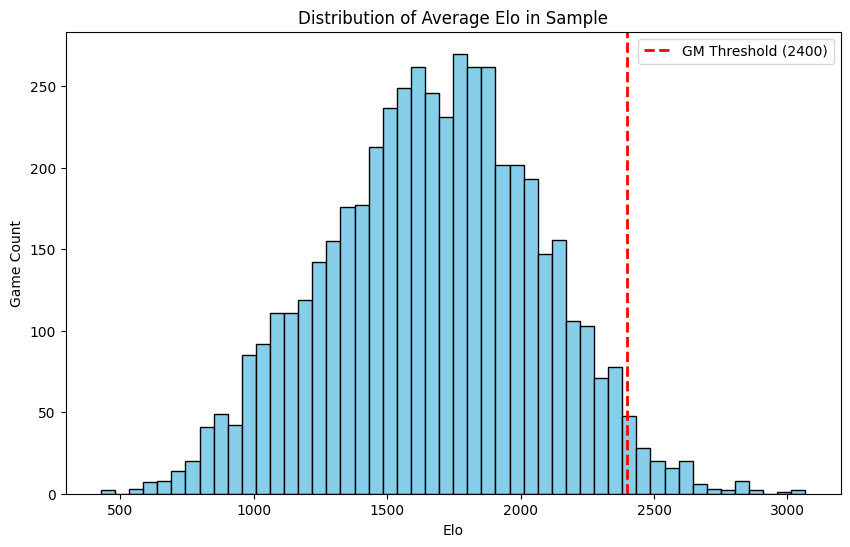

Total games sampled: 5000
Games passing Elo filter (>=2400): 140 (2.80%)


In [4]:
# Calculate Average Elo
df['AvgElo'] = (df['WhiteElo'] + df['BlackElo']) / 2

plt.figure(figsize=(10, 6))
plt.hist(df['AvgElo'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(2400, color='red', linestyle='dashed', linewidth=2, label='GM Threshold (2400)')
plt.title("Distribution of Average Elo in Sample")
plt.xlabel("Elo")
plt.ylabel("Game Count")
plt.legend()
plt.show()

# Retention Rate
gm_games = df[df['AvgElo'] >= 2400]
print(f"Total games sampled: {len(df)}")
print(f"Games passing Elo filter (>=2400): {len(gm_games)} ({len(gm_games)/len(df)*100:.2f}%)")

2.8% is actually a good ratio, if I apply it to full lichess 2 month (roughly 190 million games) I will have over 5 million games, with 5 positions per game that's 26 million training samples

# 3. Cleaning: Filtering Out Noise
Based on the sample, we identify "noisy" data that could harm the model's policy head.

Criteria:
Bullet Games: High variance, low strategic depth.

Short Games: Games ending in < 10 moves (often early resignations or blunders).

Abnormal Terminations: Disconnections or abandoned games.

In [6]:
# Debugging filters one by one
print(f"Starting with GM games: {len(df[df['AvgElo'] >= 2400])}")

f1 = df[df['AvgElo'] >= 2400]
f2 = f1[~f1['Event'].str.contains("Bullet", case=False)]
print(f"After removing Bullet: {len(f2)}")

f3 = f2[f2['Termination'] == "Normal"]
print(f"After filtering Termination == 'Normal': {len(f3)}")

f4 = f3[f3['PlyCount'].astype(int) > 20]
print(f"After filtering PlyCount > 20: {len(f4)}")

Starting with GM games: 140
After removing Bullet: 25
After filtering Termination == 'Normal': 19
After filtering PlyCount > 20: 0


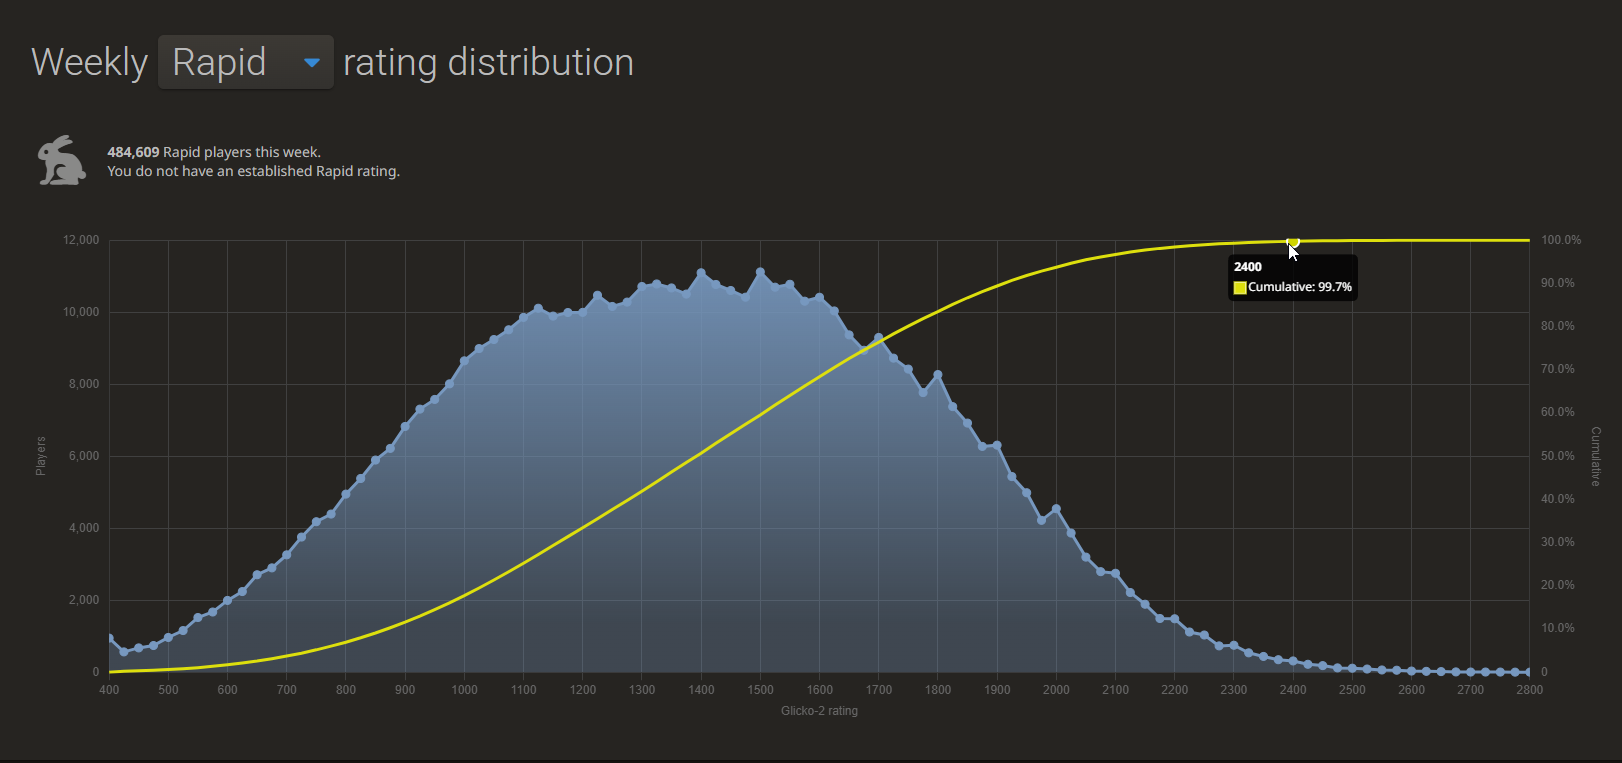

Exploratory analysis reveals that a 2400 Elo threshold is too restrictive, as it represents an extremely small fraction of the player base. To ensure a robust dataset without sacrificing quality, I've adjusted the filter to 2200+ Elo. This still targets the top 2% of players (98th percentile) while providing a significantly larger volume of training samples.

# Updated Strategy: Only Rapid & Classical (2200+ Elo)

In [7]:
# Configuration for the "High-Quality Strategy" approach
MIN_ELO = 2200

# 1. Elo Filtering (Both players must be strong)
f1 = df[(df['WhiteElo'] >= MIN_ELO) & (df['BlackElo'] >= MIN_ELO)]
print(f"Games with both players >= {MIN_ELO}: {len(f1)}")

# 2. Strict Time Control Filtering (Rapid & Classical ONLY)
# We look for 'Rapid' or 'Classical' in the Event header
f2 = f1[f1['Event'].str.contains("Rapid|Classical", case=False)]
print(f"After keeping ONLY Rapid & Classical: {len(f2)}")

# 3. Quality Termination & Length
f3 = f2[f2['Termination'].isin(['Normal', 'Mate', 'Resign'])]
f4 = f3[f3['PlyCount'].astype(int) >= 30]

print(f"FINAL high-quality games in sample: {len(f4)}")

# Let's see what events actually stayed in our sample
if len(f4) > 0:
    print("\nEvent types in your final dataset:")
    print(f4['Event'].value_counts())

Games with both players >= 2200: 396
After keeping ONLY Rapid & Classical: 6
FINAL high-quality games in sample: 0


# 5. Conclusion: The "Data Hunger" Problem & Pivoting to Gigabase
As demonstrated above, a strict filter for 2200+ Elo Rapid & Classical games on raw Lichess logs results in a massive loss of data (nearly 100% of the sample). To build a high-performance engine like ChessNet-3070, we need millions of high-quality positions, not just a few dozen.

Final Decision: Switching to Lumbras Gigabase
Instead of brute-forcing the filtration of terabytes of raw Lichess logs, this project will pivot to using Lumbras Gigabase.

Why Lumbras Gigabase?

Pre-filtered Content: It already contains curated collections like "Lichess Elite", which targets exactly the 2400+ vs 2200+ Elo demographic we need.

Deduplication: The base is already cleaned of duplicate games and engine-testing noise.

Quality over Quantity: It combines the best of Online (Lichess/Chess.com) and OTB (Over-the-Board) Grandmaster games.